<a href="https://colab.research.google.com/github/biniyam69/Loan-Eligibility-With-Gradient-Boosting-/blob/main/Loan_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer, StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib
import numpy as np
import tensorflow as tf
import torch

%matplotlib inline

In [ ]:
data = pd.read_csv("/content/LoansTrainingSetV2.csv", low_memory=False)

In [ ]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [ ]:
len(data)

111107

In [ ]:
data.drop_duplicates(subset='Loan ID', keep="first", inplace=True)

In [ ]:
status=data["Loan Status"].value_counts()

<function matplotlib.pyplot.show(close=None, block=None)>

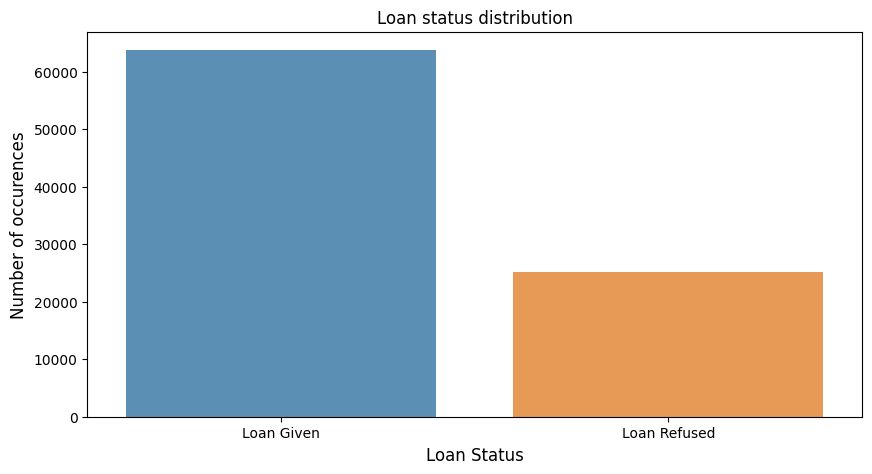

In [ ]:
#df = sns.load_dataset("/content/LoansTrainingSetV2.csv")
plt.figure(figsize=(10,5))
sns.barplot(x=status.index,y=status.values,alpha=0.8)
plt.title("Loan status distribution")
plt.ylabel("Number of occurences", fontsize=12)
plt.xlabel("Loan Status", fontsize=12)
plt.show

In [ ]:
data["Current Loan Amount"].describe()

count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

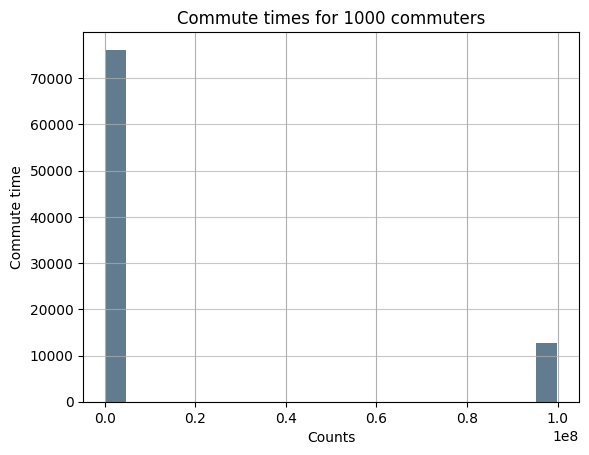

In [ ]:
data["Current Loan Amount"].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title("Commute times for 1000 commuters")
plt.ylabel("Commute time")
plt.xlabel("Counts")
plt.grid(axis='y', alpha=0.7)

In [ ]:
Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)

IQR = Q3 - Q1
print(IQR)

16202.0


In [ ]:
docum = (1, 2 , [1,2])
docum[-1].append(3)

print(docum)

(1, 2, [1, 2, 3])


In [ ]:
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) | data["Current Loan Amount"] > (Q3 + 1.5 * IQR))]

Series([], Name: Current Loan Amount, dtype: int64)

<Axes: ylabel='Frequency'>

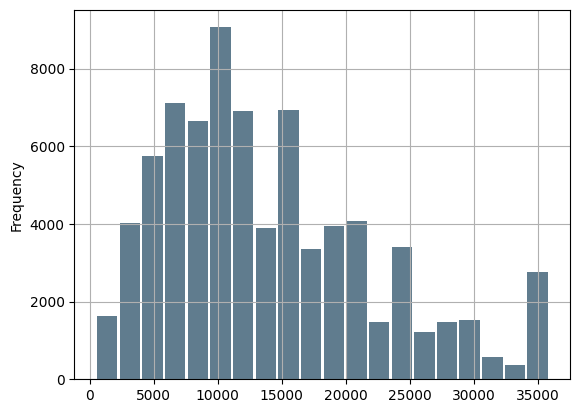

In [ ]:
temp = np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount_temp"] = np.where(temp > 999998, 'NaN', temp).tolist()
temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"] != 'NaN'].astype(str).astype(int)

temp.plot.hist(grid=True, bins=20, rwidth=0.9,color="#607c8e")

In [ ]:
temp.describe()

count    76172.000000
mean     13933.915756
std       8235.921922
min        491.000000
25%       7810.000000
50%      12038.000000
75%      19351.000000
max      35875.000000
Name: Current Loan Amount_temp, dtype: float64

In [ ]:
#Replacing the data with 50% percentile or mean

temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(temp>999998, 13286,temp).tolist()
data = data.drop("Current Loan Amount_temp", axis=1)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88910 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88910 non-null  object 
 1   Customer ID                   88910 non-null  object 
 2   Loan Status                   88910 non-null  object 
 3   Current Loan Amount           88910 non-null  int64  
 4   Term                          88910 non-null  object 
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          85093 non-null  object 
 7   Home Ownership                88910 non-null  object 
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       88910 non-null  object 
 10  Monthly Debt                  88910 non-null  object 
 11  Years of Credit History       88910 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  N

In [ ]:
data["Credit Score"].isnull().unique()

array([False,  True])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b6e0e4e8220>,
 'caps': [<matplotlib.lines.Line2D at 0x7b6e0e4e8790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b6e0e1c7f40>],
 'medians': [<matplotlib.lines.Line2D at 0x7b6e0e4e8cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b6e0e4e8f70>],
 'means': []}

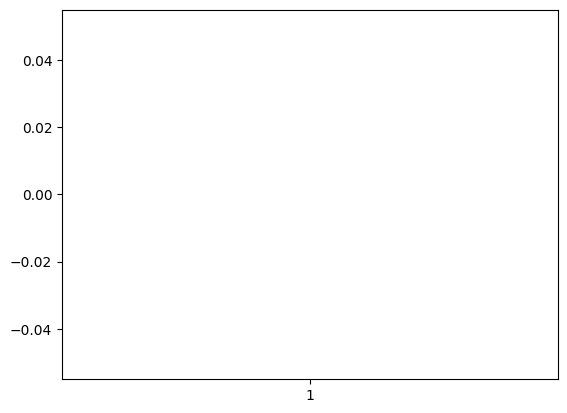

In [ ]:
plt.boxplot(data["Credit Score"])

In [ ]:
data["Credit Score"] = np.where(data["Credit Score"] > 800, data["Credit Score"]/10, data["Credit Score"])

In [ ]:
median_score = statistics.median(data["Credit Score"])

In [ ]:
data["Credit Score_1"] = data["Credit Score"]
data["Credit Score_1"].fillna(median_score, inplace=True)

In [ ]:
data["Credit Score_1"].head()

0    728.0
1    733.0
2    724.0
3    740.0
4    686.0
Name: Credit Score_1, dtype: float64

<ipython-input-37-5e15f51cf54e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["Credit Score_1"])


<Axes: xlabel='Credit Score_1', ylabel='Density'>

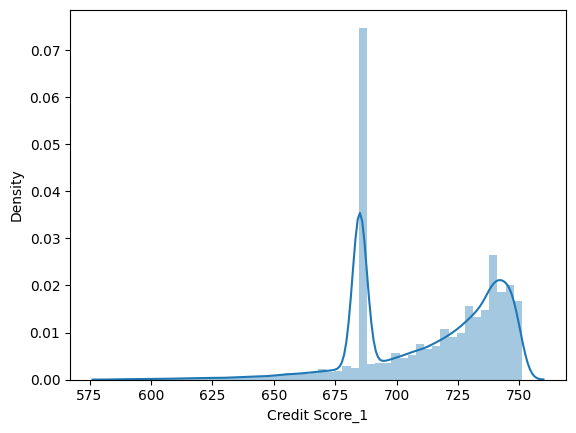

In [ ]:
sns.distplot(data["Credit Score_1"])

<ipython-input-38-f60e7466faad>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["Credit Score"])


<Axes: xlabel='Credit Score', ylabel='Density'>

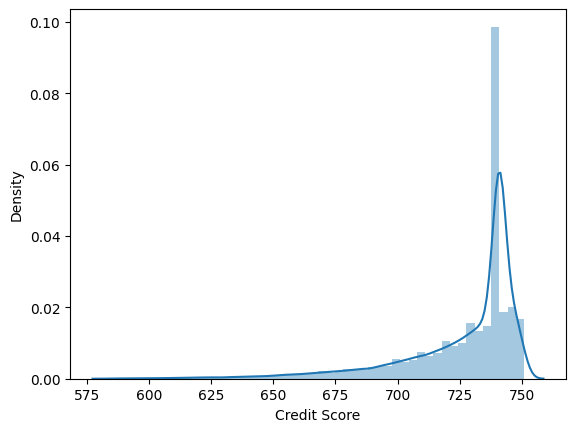

In [ ]:
data["Credit Score"].fillna(741, inplace=True)
sns.distplot(data["Credit Score"])

<ipython-input-39-b7eba8f74ed1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(data["Credit Score"]))


<Axes: xlabel='Credit Score', ylabel='Density'>

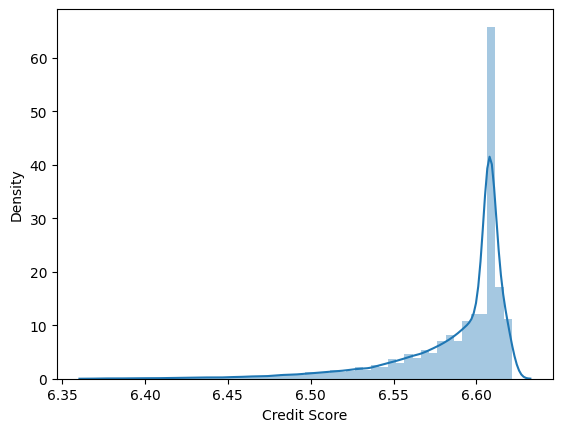

In [ ]:
sns.distplot(np.log(data["Credit Score"]))

In [ ]:
data["Home Ownership"].unique()

array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

In [ ]:
data["Home Ownership"] = data["Home Ownership"].str.replace("HaveMortgage", "Home Mortgage", regex=True)

In [ ]:
data["Home Ownership"].unique()

array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

In [ ]:
data["Annual Income"].describe()

count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [ ]:
data["Annual Income"].quantile([0.2,0.75,0.95,0.99,0.999])

0.200     40764.00
0.750     86750.25
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [ ]:
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287

In [ ]:
data["Annual Income"].isna().sum()

21338

In [ ]:
data["Purpose"].value_counts()

Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [ ]:
data["Purpose"] = data['Purpose'].str.replace('Other', 'other', regex=True)

In [ ]:
data['Purpose'].value_counts()

Debt Consolidation      70447
other                    7767
Home Improvements        5206
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [ ]:
data['Monthly Debt'].describe()

count     88910
unique    70066
top           0
freq         69
Name: Monthly Debt, dtype: object

In [ ]:
data['Monthly Debt'] = data["Monthly Debt"].str.replace("$",'',regex=True)

In [ ]:
data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'])

In [ ]:
data['Monthly Debt'].describe()

count    88910.000000
mean       963.102059
std        637.524064
min          0.000000
25%        532.220000
50%        843.925000
75%       1250.527500
max      22939.120000
Name: Monthly Debt, dtype: float64

In [ ]:
data['Monthly Debt'].quantile([0.2,0.75,0.90,0.95,0.99,0.999])

0.200     463.75000
0.750    1250.52750
0.900    1743.08300
0.950    2115.51100
0.990    3087.11100
0.999    4926.37475
Name: Monthly Debt, dtype: float64

In [ ]:
data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] =  4926

<ipython-input-56-a0a055fa903b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Monthly Debt'])


<Axes: xlabel='Monthly Debt', ylabel='Density'>

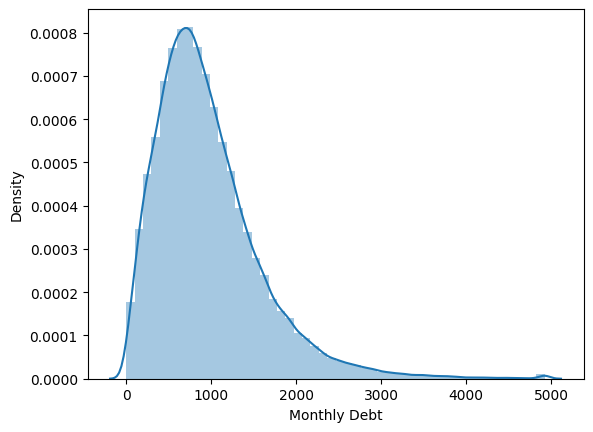

In [ ]:
sns.distplot(data['Monthly Debt'])

In [ ]:
data['Years of Credit History'].describe()

count    88910.000000
mean        18.315313
std          7.049175
min          3.600000
25%         13.500000
50%         17.000000
75%         21.800000
max         70.500000
Name: Years of Credit History, dtype: float64

<ipython-input-58-168237ab8a62>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Years of Credit History'])


<Axes: xlabel='Years of Credit History', ylabel='Density'>

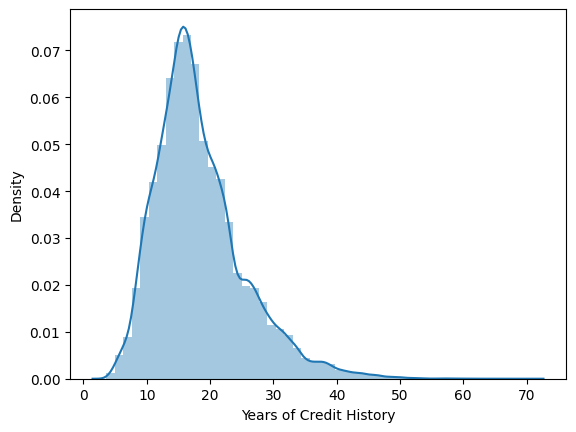

In [ ]:
sns.distplot(data['Years of Credit History'])

In [ ]:
data['Months since last delinquent'].isna().sum()

48506

In [ ]:
data['Number of Open Accounts'].describe()

count    88910.000000
mean        11.110348
std          4.978461
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

<ipython-input-61-9f2a18ccbe61>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Current Credit Balance'])


<Axes: xlabel='Current Credit Balance', ylabel='Density'>

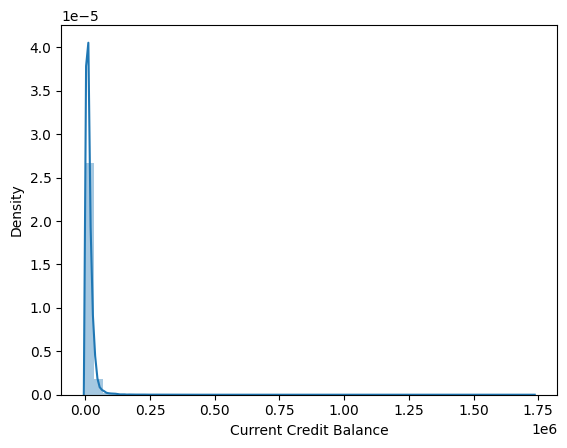

In [ ]:
sns.distplot(data['Current Credit Balance'])

In [ ]:
data['Current Credit Balance'].quantile([0.95,0.96,0.96,0.97,0.98,0.99,1])

0.95      39933.30
0.96      43501.20
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

In [ ]:
data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007

<ipython-input-64-44e8ee6e5fdd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Current Credit Balance']**(1/2))


<Axes: xlabel='Current Credit Balance', ylabel='Density'>

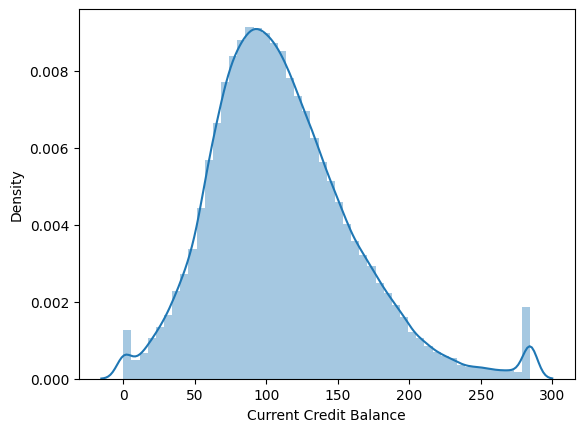

In [ ]:
sns.distplot(data['Current Credit Balance']**(1/2))

In [ ]:
data['Maximum Open Credit'].describe()

count     88910
unique    46625
top           0
freq        610
Name: Maximum Open Credit, dtype: object

In [ ]:
data['Maximum Open Credit'].value_counts()

0        610
10782     10
14382     10
17464     10
11044     10
        ... 
46635      1
25110      1
54780      1
42402      1
53374      1
Name: Maximum Open Credit, Length: 46625, dtype: int64

<ipython-input-71-78aae5c6ae52>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Maximum Open Credit'])


<Axes: xlabel='Maximum Open Credit', ylabel='Density'>

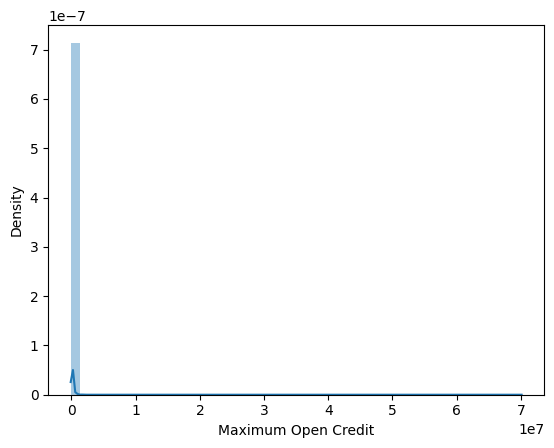

In [ ]:
sns.distplot(data['Maximum Open Credit'])

In [ ]:
data['Maximum Open Credit'] = data['Maximum Open Credit'].replace("#VALUE!", np.nan, regex=True)

In [ ]:
data['Maximum Open Credit'] = pd.to_numeric(data['Maximum Open Credit'])

In [ ]:
data['Maximum Open Credit'].isnull().sum()

2

In [ ]:
data['Maximum Open Credit'] = data['Maximum Open Credit'].fillna(35965)

In [ ]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])

0.55       24037.95
0.76       37259.84
0.87       50736.66
0.98      114682.56
0.99      171423.91
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [ ]:
data.loc[data['Maximum Open Credit'] > 171424, 'Maximum Open Credit'] = 171424

In [ ]:
data['Maximum Open Credit'].value_counts()

171424.0    890
0.0         610
11044.0      10
10782.0      10
17464.0      10
           ... 
70865.0       1
20726.0       1
32515.0       1
58164.0       1
53374.0       1
Name: Maximum Open Credit, Length: 45738, dtype: int64

<ipython-input-78-78aae5c6ae52>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Maximum Open Credit'])


<Axes: xlabel='Maximum Open Credit', ylabel='Density'>

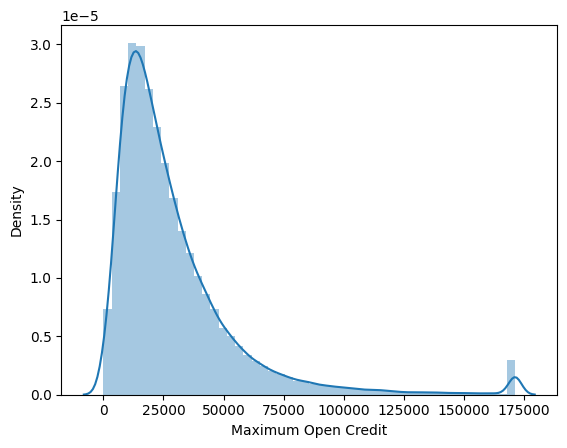

In [ ]:
sns.distplot(data['Maximum Open Credit'])

In [ ]:
data['Bankruptcies'].unique()

array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [ ]:
data['Bankruptcies']= data['Bankruptcies'].fillna(3)

In [ ]:
cat_cols = ["Term", "Years in current job", "Home Ownership", "Purpose"]

for c in cat_cols:
  data[c] = pd.factorize(data[c])[0]

In [ ]:
updated_data = pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), )